<a href="https://colab.research.google.com/github/t6nand/mloptimization/blob/master/ridge_regression_cross_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Initial setup to enable use of latex with matplotlib. Comment after first use. 

In [0]:
# ! sudo apt-get install texlive-latex-recommended #1
# ! sudo apt-get install dvipng texlive-fonts-recommended #2
# ! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip #3
# ! unzip type1cm.zip -d /tmp/type1cm #4
# ! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins  #5
# ! sudo mkdir /usr/share/texmf/tex/latex/type1cm #6
# ! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm #7
# ! sudo texhash #8

Import packages and initialize plot formatting

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import csv # For importing CSV data as python datastructure

plt.rcParams['font.size'] = 7
plt.rcParams['lines.markersize'] = 4
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 150

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

Import Features and corresponding labels from the provided CSV files.

In [0]:
# Load features with their specifiers. Standardise the features
Features = np.loadtxt('hitters.x.csv', delimiter=',', skiprows=1)
with open('hitters.x.csv', 'r') as f:
  Features_specifiers = next(csv.reader(f))
Features -= Features.mean(0)[None, :]
Features /= Features.std(0)[None, :]

# Load output label i.e. salaries in this example
Salaries = np.loadtxt('hitters.y.csv', delimiter=',', skiprows=1)

Ridge Regression with Cross Validation.

1. For 100 values of $\lambda$, evenly spaced in the interval $[10^{-3}, 10^7]$ on a logarithmic scale, compute the ridge regression solution using closed form expression with bias.

Note that ridge regression estimate with bias is as:
\begin{equation}
\hat{\underline{\theta}}_{ridge} = (X^TX + \lambda I)^{-1}X^Ty
\end{equation}
Where, $I$ is a diagonal matrix with a zero followed by all ones along it's main diagonal. This would nullify the bias weight in the $l_2$ norm penalty. Furthermore, $X$ is an augmented matrix of type $[1 X]$.  

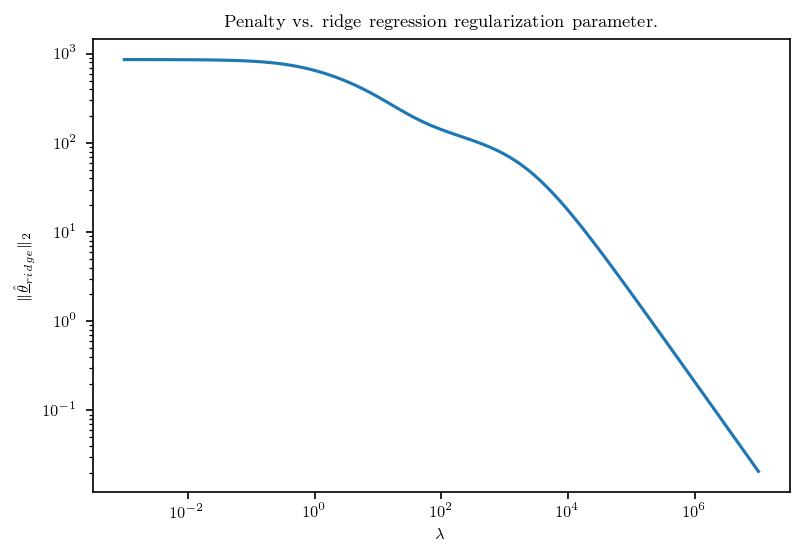

In [253]:
# Method to calculate ridge regression estimate as described by formula above.
def ridge_regression(features, output, lamda):
  theta_hat = np.linalg.inv(features.T @ features + lamda * eye) @ (features.T @ output)
  return theta_hat

# Define variables as below:
lamdas = np.logspace(-3, 7, 100) 
X_augmented = np.hstack((np.ones((Features.shape[0], 1)), Features))
eye = np.eye(X_augmented.shape[1])
eye[0, 0] = 0

# Calculate optimum ridge regression coefficients.
thetas_ridge = np.array([ridge_regression(X_augmented, Salaries, lamda) for lamda in lamdas])

# Calculate penalty term values by taking l2 norm of regression coefficients
theta_penalty = np.sqrt((thetas_ridge[:,1:] ** 2).sum(axis=1))

# Plot penalty terms with lambda to verify that as lambda decreases, penalty
# increases.
fig, ax = plt.subplots()
ax.loglog(lamdas, theta_penalty)
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\|\underline{\hat{\theta}}_{ridge}\|_2$')
plt.title('Penalty vs. ridge regression regularization parameter.')
plt.show()

This hence verifies that for the given biased augmented features, decreasing $\lambda$ increases the penalty term $\|\theta\|_2$. 

Furthermore, it can be varified that the following holds true:

1. As, $\lambda\to0$, $\hat{\theta}_{ridge}\to\hat{\theta}_{least-squares}$ 
2. As, $\lambda\to\infty$, $\hat{\theta}_{ridge}\to0$

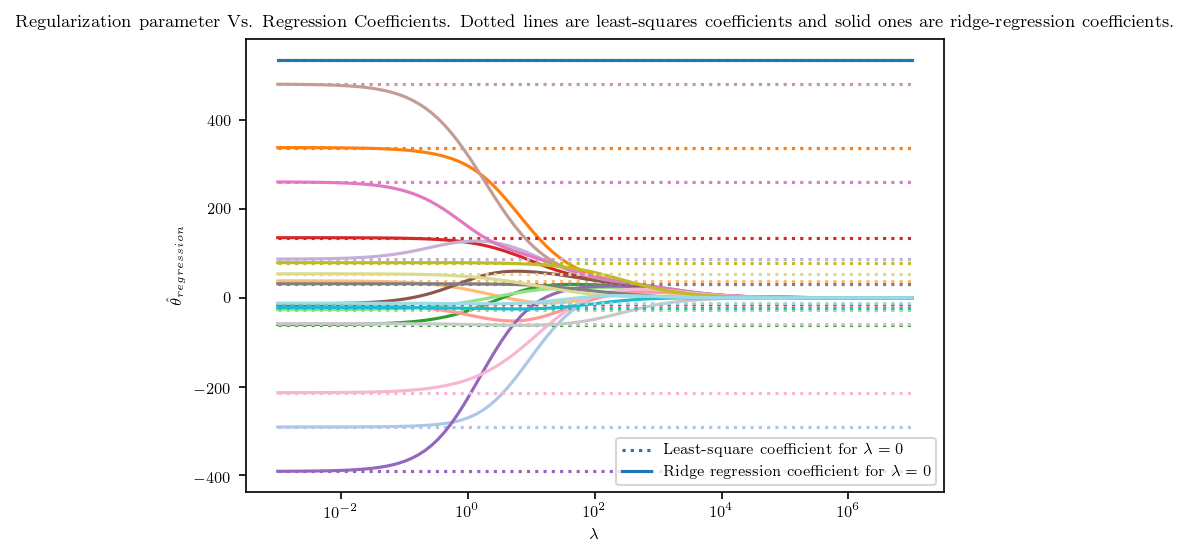

In [254]:
# Calculate the least squares regression coefficients
thetas_ls = ridge_regression(X_augmented, Salaries, 0)

# Plot the LS and RR coefficients to validate the claim
fig1, ax1 = plt.subplots()
for j, theta in enumerate(thetas_ls):
    if j == 0:
      ax1.semilogx(lamdas, np.ones_like(lamdas) * theta, ':', c=plt.cm.tab20(j/20), label='Least-square coefficient for $\lambda=0$')
      ax1.semilogx(lamdas, thetas_ridge[:, j], c=plt.cm.tab20(j/20), label='Ridge regression coefficient for $\lambda=0$')
    else:
      ax1.semilogx(lamdas, np.ones_like(lamdas) * theta, ':', c=plt.cm.tab20(j/20))
      ax1.semilogx(lamdas, thetas_ridge[:, j], c=plt.cm.tab20(j/20))
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\hat{\theta}_{regression}$')
titlestr = 'Regularization parameter Vs. Regression Coefficients. Dotted lines are least-squares coefficients and solid ones are ridge-regression coefficients.'
plt.title(titlestr)
plt.legend()
plt.show()

Now, we perform 5-fold cross validation to obtain best value for the $\lambda$ to achieve a good bias-variance tradeoff.

Plot the average cross validation error w.r.t 

Best value of lambda post 5-fold cross validation: 0.422924
Minumum Cross Validation error for best lambda: 323.906


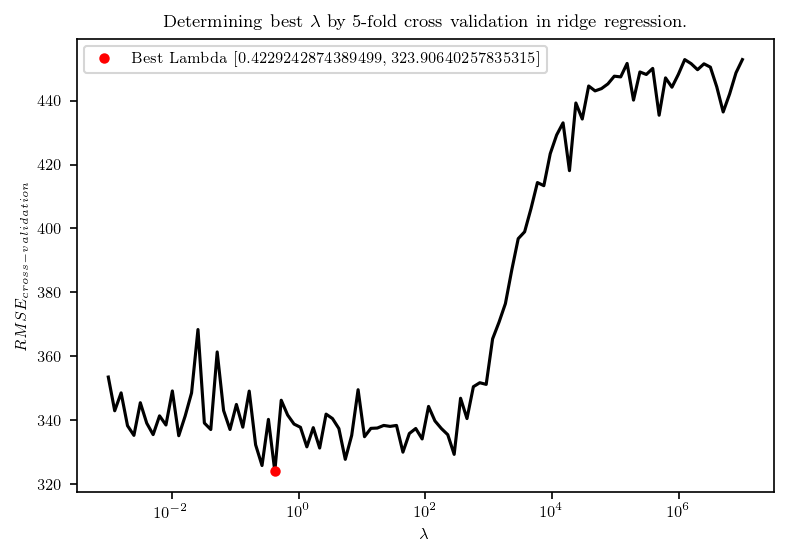

In [240]:
def ridge_regression_cv(features, output, lamda, num_folds=5):
  subset_size = features.shape[0] // num_folds # Each data subset of calculated size
  shuffel_index_ordering = np.random.permutation(features.shape[0]) # Use permutation to create a shuffeled feature indexs

  errors = np.empty((num_folds, 1)) # An empty list to keep validation error for each subset

  for k in range(num_folds):
    validation_mask = np.zeros(features.shape[0], dtype=bool) # Create a boolean validation mask
    start_idx = k*subset_size
    end_idx = (k+1) * subset_size
    validation_mask[start_idx:end_idx] = True # Set indices requred for validation.
    train_mask = np.logical_not(validation_mask) # Remaining indices will be used for training.
    X_train, X_validation = features[shuffel_index_ordering[train_mask], :], features[shuffel_index_ordering[validation_mask], :] # Separate training and validation feature data
    y_train, y_validation = output[shuffel_index_ordering[train_mask]], output[shuffel_index_ordering[validation_mask]] # Separate training and validation label data
    theta_ridge = ridge_regression(X_train, y_train, lamda) # Evaluate the ridge regression coefficients
    error = np.sqrt(((y_validation - X_validation @ theta_ridge)**2).mean()) # Evaluate RMSE
    errors[k] = error # Add RMSE for each fold to the error array
  cross_validation_error = errors.mean() # Evaluate cross validation error as average validation error for each subset.
  return cross_validation_error

# Obtain cross validation errors for each value in lambda space.
cross_validation_rmse = np.array([ridge_regression_cv(X_augmented, Salaries, lamda, num_folds=5) for lamda in lamdas])

# Calculate the index of best lambda and min. error and print it
optimum_lamda_index = np.argmin(cross_validation_rmse)
best_lamda = lamdas[optimum_lamda_index]
min_error = cross_validation_rmse[optimum_lamda_index]
print('Best value of lambda post 5-fold cross validation: %g' % best_lamda)
print('Minumum Cross Validation error for best lambda: %g' % min_error)


# Plot Cross validation error w.r.t lambda spcae
fig2, ax2 = plt.subplots()
ax2.semilogx(lamdas, cross_validation_rmse, 'k')
labelstr = r"Best Lambda $[{0}, {1}]$".format(best_lamda, min_error)
ax2.semilogx(lamdas[optimum_lamda_index], cross_validation_rmse[optimum_lamda_index], 'ro', label=labelstr)
plt.xlabel('$\lambda$')
plt.ylabel('$RMSE_{cross-validation}$')
plt.title('Determining best $\lambda$ by 5-fold cross validation in ridge regression.')
plt.legend()
plt.show()

Using these information, now we can evaluate ridge regression coefficient estimates for the best value of $\lambda$.

In [255]:
# Evaluate ridge regression coefficients at best lambda 
theta_best = ridge_regression(X_augmented, Salaries, best_lamda)

# Print ridge regression coefficients for best lambda with feature names.
for i, feat in sorted(enumerate(['bias'] + Features_specifiers), key=lambda feat_val: theta_best[feat_val[0]]):
    print("{0} : {1}".format(feat, theta_best[i]))

CAtBat : -303.2803051563751
AtBat : -283.480817795491
CWalks : -198.55975243229204
DivisionW : -59.39928785107753
Runs : -43.6140739868797
Years : -28.944118569269904
Errors : -23.05189610899754
RBI : -16.948002519511647
NewLeagueN : -13.227088048375776
CHmRun : 19.612313843933407
HmRun : 26.868775939556144
LeagueN : 31.21440878807266
Assists : 50.67693517857265
PutOuts : 78.75588335836665
CHits : 119.69524021754478
Walks : 130.04432252419133
CRBI : 198.3563874801439
Hits : 318.0344045624897
CRuns : 388.97542037701214
bias : 535.9258441064637
